# Metrics to asses the efficiency:
1. passenger / vehicle mile increment (in times): the higher the better
	
    = new(sum(# passengers) / sum(miles)) / old(sum(# passengers) / sum(miles)) 
    
    
2. vehicle count reduction percent: the higher the better
	
    = new(0.5 * # aggregated trips) / old(# trips) 
    
    
3. average straight line distance increment percent: the lower the better
	
    = avg((new distance / old distance))
    

Metric 1 and Metric 2 measure the same efficiency from two perspectives. High passenger/vehicle means less vehicles are needed.

I include both of them because Metric 1 is not reasonable to be measure in division of location, while Metric 2 is. 

Metric 3 measures the detour created by aggregation. A low distance increment means good efficiency.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point, Polygon
from datetime import datetime

%matplotlib inline

In [13]:
df_sorted = pd.read_csv('Manhattan201606FirstWeek_sorted.csv', \
                        parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
match_df = pd.read_csv('matched2.csv')
df = df_sorted.merge(match_df, left_on='index', right_on='id', how='left')
df.head()

,Unnamed: 0,index,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,index_pick,boro_pick,index_drop,boro_drop,distance_line,bearing,id,match_id,new_distance,tot_saved_mile
0,0,676838,2016-06-06 00:00:01,2016-06-06 00:04:05,2,1.37,-73.980690,40.742210,-73.967842,40.759029,...,3.0,Manhattan,3.0,Manhattan,1.342635,30.053450,NaN,NaN,NaN,NaN
1,1,151367,2016-06-06 00:00:02,2016-06-06 00:03:36,1,0.90,-73.986794,40.756310,-73.976067,40.763119,...,3.0,Manhattan,3.0,Manhattan,0.732467,50.032033,NaN,NaN,NaN,NaN
2,2,676840,2016-06-06 00:00:03,2016-06-06 00:11:18,1,2.65,-74.006348,40.733410,-74.008247,40.704369,...,3.0,Manhattan,3.0,Manhattan,2.009023,182.838955,NaN,NaN,NaN,NaN
3,3,151368,2016-06-06 00:00:03,2016-06-06 00:12:41,1,3.90,-73.992607,40.748741,-73.950554,40.779106,...,3.0,Manhattan,3.0,Manhattan,3.040531,46.354843,NaN,NaN,NaN,NaN
4,4,676842,2016-06-06 00:00:06,2016-06-06 00:07:20,1,1.19,-73.983177,40.738621,-73.993767,40.749931,...,3.0,Manhattan,3.0,Manhattan,0.958127,324.654003,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'trip 2')

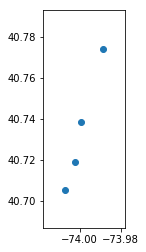

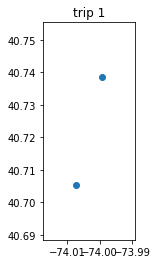

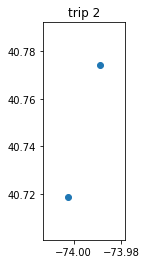

In [68]:
# an example of an aggregated trip
x0 = df.iloc[21]
a0 = Point(x0['pickup_longitude'], x0['pickup_latitude'])
b0 = Point(x0['dropoff_longitude'], x0['dropoff_latitude'])



x1 = df.iloc[29]
a1 = Point(x1['pickup_longitude'], x1['pickup_latitude'])
b1 = Point(x1['dropoff_longitude'], x1['dropoff_latitude'])




geopandas.GeoSeries([a0, b0, a1, b1]).plot()
geopandas.GeoSeries([a0, b0]).plot()
plt.title('trip 1')
geopandas.GeoSeries([a1, b1]).plot()
plt.title('trip 2')

In [15]:
# add neighborhood column: pickup location
def neighborhood(x):
    if x >= 40.763814: # JW Marriott Essex House New York
        return 'Upper'
    elif x < 40.738339: # 14 Street - Union Sq Station
        return 'Lower'
    else:
        return 'Midtown'
    
df['pickup_neighborhood'] = df['pickup_latitude'].apply(neighborhood)

# add distance_change column: 
df['distance_change'] = df['new_distance'] / df['distance_line']

In [61]:
def passenger_per_mile(df):
    # the first metric: passenger / vehicle mile reduction percent: the higher the better
    saved_miles = df['tot_saved_mile'].sum() / 2 # this value appears twice because of paired rides
    passenger_sum = df['passenger_count'].sum()
    distance_sum = df['distance_line'].sum()

    origin_ppm = passenger_sum / distance_sum # original passenger per mile
    new_ppm = passenger_sum / (distance_sum - saved_miles) # new passenger per mile

    return (origin_ppm, new_ppm, new_ppm / origin_ppm)

In [17]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayname'] = df['tpep_pickup_datetime'].dt.day_name()
df['pickup_datehour'] = df['tpep_pickup_datetime'].apply(lambda x: x.replace(microsecond=0,second=0,minute=0))

# Overall passenger per mile change in times (metric 1)
The overall passenger per mile increases 12% after aggregating.

In [65]:
(origin_ppm, new_ppm, percent_change) = passenger_per_mile(df)
print('origin passenger per mile:', origin_ppm)
print('new passenger per mile:', new_ppm)
print('change of passenger per mile in times:', (percent_change))

origin passenger per mile: 0.8259663605265551
new passenger per mile: 0.9255169103074794
change of passenger per mile in times: 1.1205261552267827


# Time variation for passenger per mile (ppm) and metric 1
There is a clear periodic cycle of ppm in a day. ppm reaches a trough between 3 am and 5am, and reaches a peak at about 3 pm. The percent change of ppm is low for troughs and peaks (but the absolute increment is high), and it is high between the peaks and troughs. 


### Business implications:
Since ppm are lower during the weekend than the week days, it would be better to design a different aggregation algorithm for weekends. For instance, we may change the 30-second bucket to 45-second bucket in order to aggregating more trips.

Text(0.5, 1.0, 'Fig 1. Time variation for passenger permile')

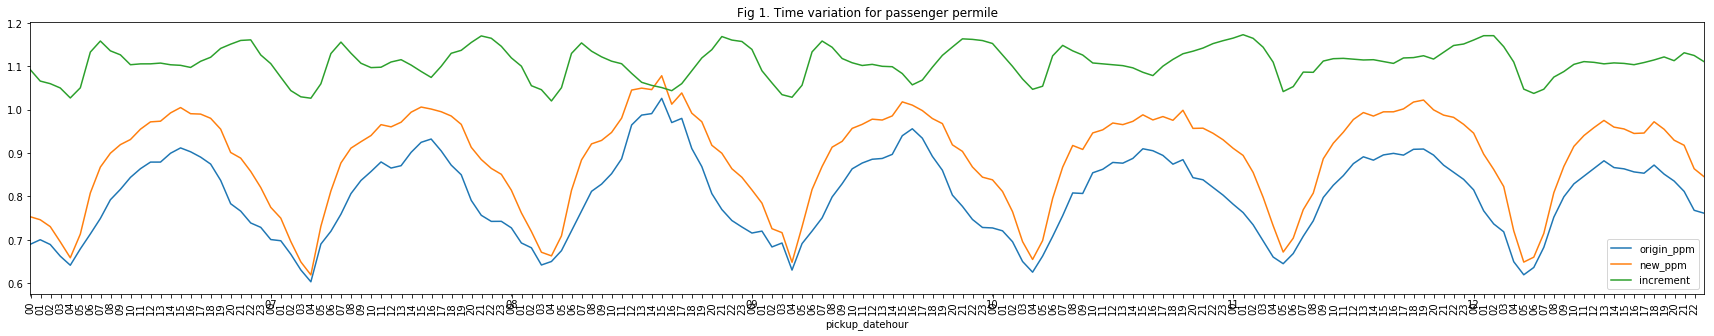

In [62]:
import matplotlib.dates as mdates
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.ticker as ticker

temp_df = []

temp = df.groupby('pickup_datehour').sum()
for i in range(24*7):
    temp_df.append(passenger_per_mile(temp.iloc[i]))
    
temp_df = pd.DataFrame(temp_df)
temp_df.index = temp.index
temp_df.columns = ['origin_ppm', 'new_ppm', 'increment']
ax = temp_df.plot(figsize=(30,5))#, x_compat=True)

hours = mdates.HourLocator(byhour=1,interval=1)
# hours.MAXTICKS = 500000
ax.xaxis.set_major_locator(hours)

ticklabels =temp_df.index.strftime('%H')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))


plt.xticks(rotation=90)
plt.legend()
plt.title('Fig 1. Time variation for passenger per mile and metric 1')

# Overall vehicle count reduction percent (metric 2)

In [34]:
def vehicle_reduction(df):
    return .5 * df['match_id'].notna().sum() / df.shape[0]

# overall
print('Overall vehicle reduction percent')
print(100 * vehicle_reduction(df), '%')

Overall vehicle reduction percent
14.368840241356736 %


# Time-location variation for metric 2
As shown in Fig 2., in all three areas, there is a clear periodic cycle of metric 2 in a day. metric2 reaches a trough between 3 am and 5am and a second low trough between 11 am to 3 pm. Metric 2 reaches peaks at rush hours. That is, our aggregating algorithm is doing a good job in reducting vehicles during the rush hours, which is very helpful to ease the traffic.

In terms of location variation, it seems during the evening peak, metric2 in Upper Manhattan is always lower than lower and midtown, and it is not because of the high vehicle volumn in Upper, as shown in the Fig 3.



### Business implications:
We should look at what is happening in Upper Mahattan and redesign our aggregating algorithm for this Area.
Also, for Via, high metric2 indicates that there is a great opportunity of Via to provide more rides in during these hours in that location.

Text(0.5, 1.0, 'Vehicle count reduction percent in each area over time')

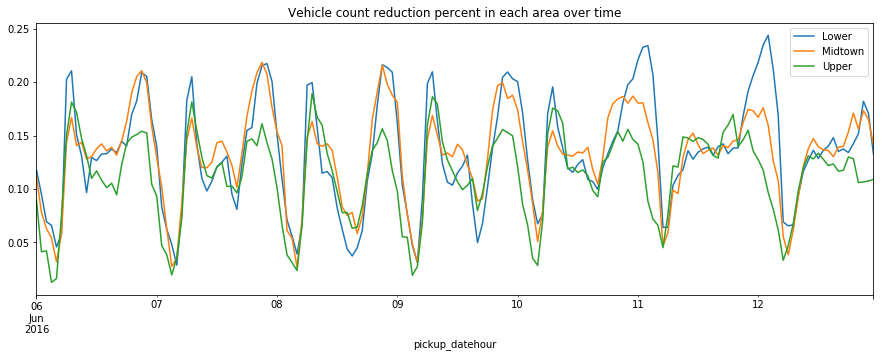

In [43]:
temp = df.groupby(['pickup_neighborhood', 'pickup_datehour']).apply(lambda x: vehicle_reduction(x))
for loc in ['Lower', 'Midtown', 'Upper']:
    temp[loc].plot(figsize=(15,5), label=loc)

plt.legend()
plt.title('Fig 2. Vehicle count reduction percent in each area over time')

Text(0.5, 1.0, 'Number of vehicles in each area over time')

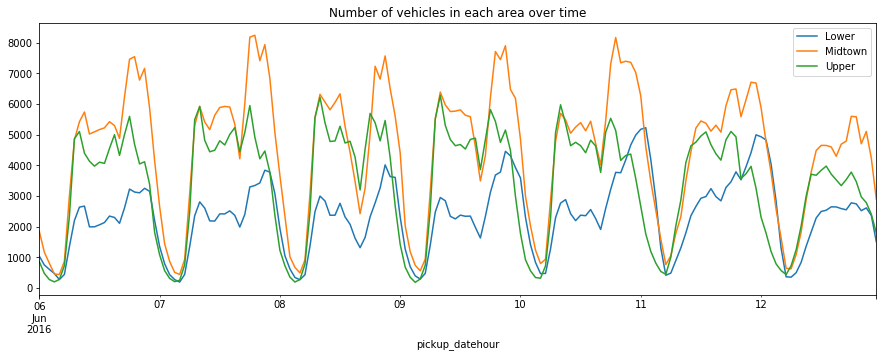

In [39]:
temp = df.groupby(['pickup_neighborhood', 'pickup_datehour']).count()['index']
for loc in ['Lower', 'Midtown', 'Upper']:
    temp[loc].plot(figsize=(15,5), label=loc)
plt.legend()
plt.title('Fig 3. Number of vehicles in each area over time')

# Overall average straight line distance increment in percent (metric 3)

mean    3.937537
50%     1.062451
Name: distance_change, dtype: float64


Text(0.5, 1.0, 'Fig 4. Histogram of average straight line distance increment (%)')

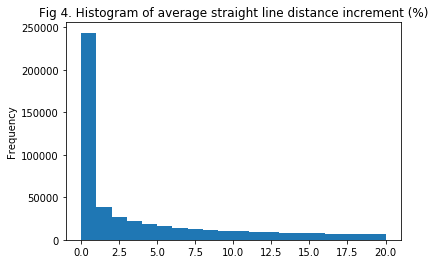

In [53]:
print((df['distance_change'].describe()[['mean', '50%']] - 1) * 100)
((df['distance_change'].sort_values() - 1) * 100).plot('hist', bins=20)
plt.title('Fig 4. Histogram of average straight line distance increment (%)')

# Time-location variation for metric 3
Generally speaking, the average increment of distance is very low, in most of time in all areas, which indicates that the algorithm is doing a good job to avoid detour. Yet there is some suspicious peaks (for Lower) and troughs (for Upper) during early am. 


### Business implications:
Perhaps during the early am in Upper, there are a great amount of demand to take rides. For Via, we can put more lines there to fulfill this potential demand. 

Text(0.5, 1.0, 'Fig 5. average straight line distance increment (%)')

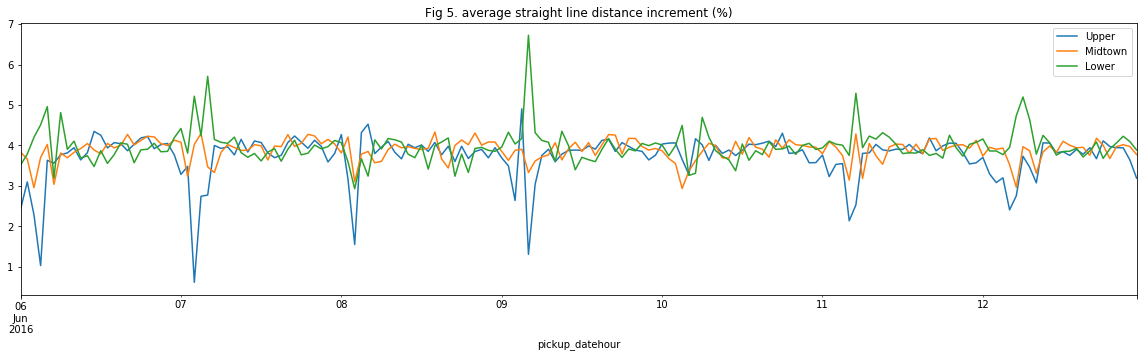

In [56]:
temp = df.groupby(['pickup_neighborhood', 'pickup_datehour']).apply(lambda x: (x['distance_change'].mean() - 1)*100)
nrows = 3
ncols = 1
plt.figure(figsize=(ncols*4, nrows*3))

locs = ['Upper', 'Midtown', 'Lower']
for i in range(3):
    loc = locs[i]
    temp[loc].plot(figsize=(20,5), label=loc, )
plt.legend()
plt.title('Fig 5. average straight line distance increment (%)')